# Reclassifying data incorrectly flagged as “missing”

Sometimes we’re happy with the type that ptype infers for a column, but discover that it has incorrectly treated some values as “missing” or “NA”. We can remedy this by updating the set of values that ptype treats as “missing”, and then rerunning the analysis. We illustrate this with a simple data visualisation task where a column contains the string `NA` as a legitimate data value.

In [167]:
# Preamble to run notebook in context of source package.
import sys
sys.path.insert(0, '../')

### Rodents Dataset
The dataset contains information about animals captured in traps as part of a 25-year study of rodents in the Chihuahuan Desert near Portal, Arizona. (The animals caught in the traps are not necessarily rodents, however.) We consider the task of visualizing how the number of captured animals of various species varies over the annual cycle. We start by reading the dataset with the `dtype='str'` option, allowing us to process the dataframe with ptype. For this simple task, we are only interested in the columns `mo` (month) and `species`.

In [175]:
import pandas as pd
from ptype.Ptype import Ptype

df = pd.read_csv('../data/rodents.csv', encoding="ISO-8859-1", dtype='str', keep_default_na=False)
df = df.sample(1000, random_state=0) # we’ll consider only 1000 rows
df = df[['mo', 'species']]
df

,mo,species
13507,9,DO
2223,2,DM
28511,3,RM
23963,1,PM
22343,9,NA
...,...,...
11211,5,DM
25737,3,PF
6770,8,DM
13766,10,DO


If we ask ptype to make its best guess at the column types, we see that the `mo` column is interpreted as integer, and the `species` column as a string. However, by default ptype treats the string value `NA`, found in the `species` column, as a missing value.

In [176]:
ptype = Ptype()
schema = ptype.schema_fit(df)
schema.show()

,mo,species
type,integer,string
normal values,"[1, 10, 11, 12, 2, 3, 4, 5, 6, 7, 8, 9]","[AB, AH, BA, CB, CM, DM, DO, DS, DX, OL, OT, O..."
missing values,[],"[, NA]"
anomalous values,[],[]


When we convert the dataframe to a “typed” version, the months are promoted to integers, and the string value `NA` is converted into the distinguished Pandas value `pd.NA` (here rendered as `<NA>`), which represents missing data.

In [177]:
df2 = schema.transform(df)
df2

,mo,species
13507,9,DO
2223,2,DM
28511,3,RM
23963,1,PM
22343,9,<NA>
...,...,...
11211,5,DM
25737,3,PF
6770,8,DM
13766,10,DO


However, we know from the metadata that `NA` is actually an abbreviation which stands for the species name *neotoma albigula*, and so we need to tell ptype to treat `NA` as a normal value instead. Ptype has many values which by default it assumes mean “missing”; we can look at some of the relevant ones:

In [178]:
na_values = ptype.machines.get_na_values()
print([x for x in na_values if x.startswith('NA')])

['NA', 'NA ', 'NAN']


And then we can remove the one we don’t want, and update ptype:

In [179]:
na_values.remove('NA')
ptype.machines.set_na_values(na_values)

Re-analysing the dataframe now shows that `NA` is treated correctly as a regular string value.

In [180]:
df2 = ptype.schema_fit(df).transform(df)
df2

,mo,species
13507,9,DO
2223,2,DM
28511,3,RM
23963,1,PM
22343,9,NA
...,...,...
11211,5,DM
25737,3,PF
6770,8,DM
13766,10,DO


There may of course be other values in the `species` column which ptype still interprets as missing; as a sanity-check we can examine these. In this case, we can see that there were several rows where the `species` column was empty.

In [181]:
df[['species']][df2[['species']].isna()]

,species
13507,NaN
2223,NaN
28511,NaN
23963,NaN
22343,NaN
...,...
11211,NaN
25737,NaN
6770,NaN
13766,NaN


With our correctly interpreted data, we can now plot how count per species varies monthly, as we originally set out to do. Let’s restrict ourselves to the 5 most populous species.

In [182]:
top_5 = list(df2.groupby(['species'])['mo'].count().sort_values(ascending=False)[:5].index)
top_5

['DM', 'DO', 'PP', 'PB', 'RM']

In [185]:
df3 = df2.loc[df2['species'].isin(top_5)].copy()
df3

,mo,species
13507,9,DO
2223,2,DM
28511,3,RM
11185,4,DM
34765,7,PB
...,...,...
14268,5,DO
11211,5,DM
6770,8,DM
13766,10,DO


In [186]:
df3['count'] = 1
df4 = df3.groupby(['mo','species']).count()['count']
df4.head(30)

mo  species
1   DM         32
    DO         10
    PB          6
    PP          3
    RM         10
2   DM         29
    DO          8
    PB          4
    RM          7
3   DM         33
    DO          9
    PB          3
    PP          7
    RM         17
4   DM         33
    DO         14
    PB          2
    PP          8
    RM          9
5   DM         29
    DO          5
    PB          5
    PP         13
    RM          5
6   DM          9
    DO          5
    PB          7
    PP          6
    RM          3
7   DM         29
Name: count, dtype: int64

TypeError: no numeric data to plot

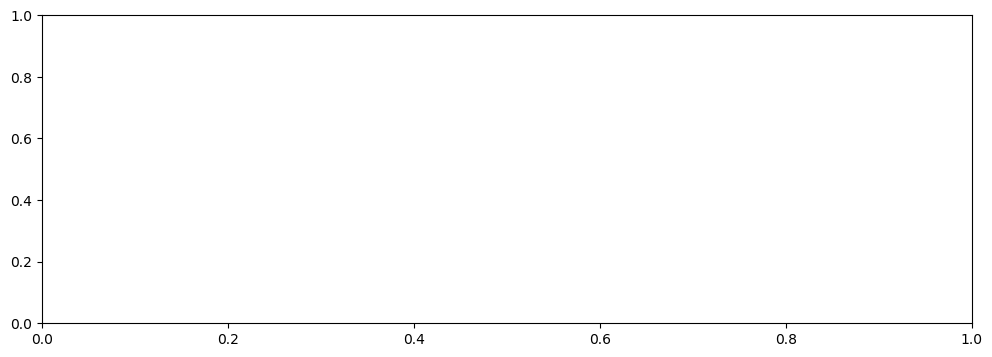

In [165]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcdefaults()

_, ax = plt.subplots(figsize=(12,4))
_ = df4.unstack().plot(ax=ax)